# Crear Web API para utilizar modelos entrenados de StarWars con TensorFlow+Keras usando Flask y ngrok
Fuentes:

https://blog.keras.io/building-a-simple-keras-deep-learning-rest-api.html

https://deeplizard.com/learn/video/SI1hVGvbbZ4

https://curiousily.com/posts/deploy-keras-deep-learning-project-to-production-with-flask/

https://pyngrok.readthedocs.io/en/latest/integrations.html#google-colaboratory

# Cargar Modelos ya entrenados

In [1]:
#@title Accede al Drive

# Acceder al drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
# @title Cargar Modelo para Datos ya entrenado con sus complementos {"single-column":true}
import os
import joblib
import tensorflow
from sklearn import tree
from tensorflow.keras.models import load_model

cargar_modelo_datos = True #@param {type:"boolean"}
path_modelo_datos = '/content/gdrive/MyDrive/demosColab/demoStarWars/modelos/datosInduccionV2'  #@param {type:"string"}

datos_model = None
if cargar_modelo_datos:
    # cargar modelo
    fn_model = path_modelo_datos+"/model.keras"
    if os.path.isfile(fn_model):
      datos_model = load_model(fn_model)
      es_keras_datos_model = True
      # muestra modelo
      datos_model.summary()
    else:
      fn_model = path_modelo_datos+"/model.joblib"
      datos_model = joblib.load(fn_model)
      es_keras_datos_model = False
      # muestra las reglas
      r = tree.export_text(datos_model)
      print("> Reglas:" )
      print(r)
    print("\n* Modelo cargado de ", fn_model, "\n")

    # cargar scaler (si existe)
    fn_scaler = path_modelo_datos+"/scaler.joblib"
    if os.path.isfile(fn_scaler):
      datos_scaler = joblib.load(fn_scaler)
      print("\n* Scaler cargado de ", fn_scaler, "\n")
    else:
      datos_scaler = None
      print("\n* Scaler no encontrado en ", fn_scaler, "\n")

    fn_clases = path_modelo_datos +"/CLASES_MAP.txt"
    datos_CLASES = []
    if os.path.isfile(fn_clases):
      with open(fn_clases, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        id, desc = c.replace("\n", "").split(":")
        datos_CLASES.append(desc)
      print("\n* CLASES definidas cargado de ", fn_clases, ":")
      print("\t\t", datos_CLASES, "\n")
    else:
      print("\n* CLASES no encontradas en ", fn_clases, "\n")


> Reglas:
|--- feature_1 <= 16.30
|   |--- feature_2 <= 83.50
|   |   |--- feature_2 <= 77.50
|   |   |   |--- class: 7
|   |   |--- feature_2 >  77.50
|   |   |   |--- feature_3 <= 30.50
|   |   |   |   |--- class: 10
|   |   |   |--- feature_3 >  30.50
|   |   |   |   |--- class: 7
|   |--- feature_2 >  83.50
|   |   |--- feature_0 <= 15.50
|   |   |   |--- feature_3 <= 15.00
|   |   |   |   |--- class: 4
|   |   |   |--- feature_3 >  15.00
|   |   |   |   |--- class: 4
|   |   |--- feature_0 >  15.50
|   |   |   |--- feature_0 <= 18.50
|   |   |   |   |--- feature_2 <= 102.50
|   |   |   |   |   |--- class: 9
|   |   |   |   |--- feature_2 >  102.50
|   |   |   |   |   |--- class: 9
|   |   |   |--- feature_0 >  18.50
|   |   |   |   |--- feature_4 <= 9.50
|   |   |   |   |   |--- feature_1 <= 6.45
|   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |--- feature_1 >  6.45
|   |   |   |   |   |   |--- class: 8
|   |   |   |   |--- feature_4 >  9.50
|   |   |   |   |   |--- clas

In [3]:
# @title Cargar Modelo para Imágenes ya entrenado con sus complementos {"single-column":true}
import os
import joblib
import tensorflow
from tensorflow.keras.models import load_model

cargar_modelo_imagenes = True #@param {type:"boolean"}
path_modelo_imagenes = '/content/gdrive/MyDrive/demosColab/demoStarWars/modelos/ImagMLP'  #@param {type:"string"}

from PIL import Image
from keras.preprocessing.image import img_to_array

DEFAULT_WEB_PAGE = None

def prepare_image(image):
  global IMAGE_SHAPE
  # ajusta el tamaño
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  imag = image.convert(tipoImage)
  # resize the input image and preprocess it
  imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)
  imag = img_to_array(imag)
  imag = np.expand_dims(imag, axis=0)
  # return the processed image
  return imag

img_model = None
if cargar_modelo_imagenes:
    # cargar modelo
    fn_model = path_modelo_imagenes+"/model.keras"
    img_model = load_model(fn_model)
    print("\n* Modelo cargado de ", fn_model, "\n")
    img_model.summary()

    fn_imageShape = path_modelo_imagenes+"/IMAGE_SHAPE.txt"
    IMAGE_SHAPE = []
    if os.path.isfile(fn_imageShape):
      with open(fn_imageShape, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        IMAGE_SHAPE.append( int(c.replace("\n", "")) )
      print("\n* IMAGE_SHAPE definido cargado de ", fn_imageShape, ":")
    else:
      # intenta toma input shape del modleo
      try:
        IMAGE_SHAPE = list(img_model.layers[0].output_shape[0][1:])
      except :
        IMAGE_SHAPE = [32, 32, 3] # valor por defecto
      print("\n* IMAGE_SHAPE no encontrado en ", fn_imageShape, " -> se usa valor por defecto:")
    print("\t\t", IMAGE_SHAPE, "\n")


    fn_clases = path_modelo_imagenes+"/CLASES_MAP.txt"
    img_CLASES = []
    if os.path.isfile(fn_clases):
      with open(fn_clases, 'r') as f:
        # carga datos
        auxData = f.readlines()
      for c in auxData:
        id, desc = c.replace("\n", "").split(":")
        img_CLASES.append(desc)
      print("\n* CLASES definidas cargado de ", fn_clases, ":")
      print("\t\t", img_CLASES, "\n")
    else:
      print("\n* CLASES no encontradas en ", fn_clases, "\n")



* Modelo cargado de  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/ImagMLP/model.keras 



Model: "RNA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slng_1_div_255 (Rescaling)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_1 (Dense)                  │ (None, 520)            │     6,390,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_2 (Dense)                  │ (None, 128)            │        66,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_4 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,403,102 (74.02 MB)

 Trainable params: 6,467,700 (24.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,935,402 (49.34 MB)


* IMAGE_SHAPE definido cargado de  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/ImagMLP/IMAGE_SHAPE.txt :
		 [64, 64, 3] 


* CLASES definidas cargado de  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/ImagMLP/CLASES_MAP.txt :
		 ['Command Ships', 'Heavy Ships', 'Landing Craft', 'Medium Ships', 'Other Starfighters', 'Patrol Craft', 'Shuttles', 'TIE Bombers', 'TIE Experimental Craft', 'TIE Fighters', 'TIE Support Craft', 'Transporters'] 



# Preparar Web API

In [4]:
#@title Instalar pyngrok (opcional)

usar_ngrok_web_publica = True #@param{type:"boolean"}

if usar_ngrok_web_publica:
  # Instalar pyngrok
  !pip install pyngrok
  print("")
else:
  print("- no se usa ngrok.")


In [5]:
#@title Preparar la conexión con ngrok para hacer sitio público (opcional)

ngrok_auth_token = "" #@param {type:"string"}


if usar_ngrok_web_publica:
  import getpass
  from pyngrok import ngrok, conf

  # determina el authentication token de ngrok (
  if (ngrok_auth_token == ""):
    print("Ingrese el authtoken indicada en https://dashboard.ngrok.com/get-started/your-authtoken luego de registrarse")
    conf.get_default().auth_token = getpass.getpass()
  else:
    conf.get_default().auth_token = ngrok_auth_token
  print("")
  # Open a TCP ngrok tunnel to the SSH server
  connection_string = ngrok.connect("22", "tcp").public_url
  print("")
  ssh_url, port = connection_string.strip("tcp://").split(":")
  print("")
  print(f" * se crea ngrok tunnel, accediendo con `ssh root@{ssh_url} -p{port}`")
else:
  print("- no se usa ngrok.")


Ingrese el authtoken indicada en https://dashboard.ngrok.com/get-started/your-authtoken luego de registrarse
··········



 * se crea ngrok tunnel, accediendo con `ssh root@6.tcp.ngrok.io -p17064`


In [6]:
#@title Define default Web Page

DEFAULT_WEB_PAGE = '''
<!DOCTYPE html>
<html>
<head>
    <title>Star Wars Image Processor</title>
    <style>
        @font-face {
            font-family: 'Star Jedi';
            font-weight: normal;
            font-style: normal;
        }

        body {
            background-image: url('https://lumiere-a.akamaihd.net/v1/images/open-uri20150608-27674-152f5g1_e6c3a14b.jpeg'); /* Replace with a suitable Star Wars background image URL */
            background-size: cover;
            background-repeat: no-repeat;
            background-attachment: fixed;
            color: #3333cc; /* Star Wars blue */
            font-family: sans-serif;
            text-align: center;
            padding: 20px;
        }

        .star-wars-font {
            font-family: 'Star Jedi', sans-serif;
            color: #ffe81f; /* Star Wars yellow */
            text-shadow: 0 0 5px #4ee4e7, 0 0 10px #4ee4e7, 0 0 15px #4ee4e7, 0 0 20px #4ee4e7;
        }

        input[type="file"] {
            display: block;
            margin: 20px auto;
            padding: 10px;
            background-color: #000;
            color: #ffe81f;
            border: 2px solid #ffe81f;
            cursor: pointer;
        }

        button {
            background-color: #ffe81f;
            color: #000;
            border: none;
            padding: 10px 20px;
            font-size: 16px;
            cursor: pointer;
            transition: background-color 0.3s ease;
        }

        button:hover {
            background-color: #fff;
        }

        #imagePreview {
            margin-top: 20px;
            border: 2px dashed #ffe81f;
            padding: 10px;
            min-height: 200px;
            display: flex;
            justify-content: center;
            align-items: center;
        }
    </style>
</head>
<body>
    <h1 class="star-wars-font">Imperial Image Processing Unit</h1>
    <br>  URL Web API:  <input type="text" size="100" class="form-control" id="URLWebAPI_imag" value=""/><br>
    <input type="file" id="imageUpload" accept="image/*">
    <div id="imagePreview">
        <!-- Image preview will be displayed here -->
    </div>
    <button id="processButton">Procesar Imagen</button>
    <br><br><br>
    <span>-Resultado Modelo:</span> <span id="resultText"></span>
    <br> <br> <br>
    <script>
        const imageUpload = document.getElementById('imageUpload');
        const imagePreview = document.getElementById('imagePreview');
        const processButton = document.getElementById('processButton');
        let resText = document.getElementById("resultText");

        imageUpload.addEventListener('change', function(event) {
            const file = event.target.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    const img = document.createElement('img');
                    img.src = e.target.result;
                    img.style.maxWidth = '100%';
                    img.style.maxHeight = '400px'; // Limit preview size
                    imagePreview.innerHTML = ''; // Clear previous preview
                    imagePreview.appendChild(img);
                }
                reader.readAsDataURL(file);
            } else {
                imagePreview.innerHTML = ''; // Clear preview if no file is selected
            }
        });

            // función para ejecutar modelo con los datos usando Web API
            async function executeModel(file_img) {
              return new Promise( (resolve, reject) => {
                const xhr = new XMLHttpRequest();
                xhr.open("POST", document.getElementById("URLWebAPI_imag").value);
                xhr.setRequestHeader("ngrok-skip-browser-warning", "69420");
                var formData = new FormData();
                formData.append('image', file_img);
                xhr.onload = function () {
                  if (xhr.status == 200) {
                    console.log("Model API response: " + xhr.responseText);
                    resolve(JSON.parse(xhr.responseText));
                  } else {
                    console.log("Error al ejecutar Web API: " + xhr.status + " " + xhr.responseText);
                    reject("ERROR");
                  }
                };
                xhr.onerror = function () {
                    console.log("Error al ejecutar Web API: " + xhr.status + " " + xhr.responseText);
                    reject("ERROR");
                };
                xhr.send(formData);
              });
            }

            // función para realizar la clasificación, ejecutando el modelo y formateando el resultado
            async function clasificar() {
              console.log('Procesando!');
              // determina imagen
              const file = imageUpload.files[0];
              console.log(file);
              // ejecuta modelo
              const resModel = await executeModel(file);
              console.log( "Clasificar: -> " + JSON.stringify(resModel) + "");
              // devuelve resultados
              if (resModel != null) {
                return "Clase ID " + resModel.data.claseID + " - " + resModel.data.clase;
              } else {
                return "NO DEFINIDO!";
              }
            }


        processButton.addEventListener('click', async () => {
              const res = await clasificar();
              resText.innerText = "--> " + res;
        });


    </script>
</body>
</html>
'''



print("\n* Web Page definida (volver a ejecutar si se necesita realizar algún cambio).\n")


* Web Page definida (volver a ejecutar si se necesita realizar algún cambio).



In [29]:
# @title Habilitar Web API con Flash {"single-column":true}

import threading
import pandas as pd
import io
from flask import Flask, jsonify, request, current_app
import numpy as np
import logging
import uuid
import os


# controla que se haya cargado al menos un modelo
if (datos_model is None) and (img_model is None):
  raise Exception("No existen modelo cargados para usar!!!")

# crea la application
app = Flask(__name__)

# define parámetros
local_port = "55555" #@param {type:"string"}
nombre_servicio_datos = "/SWdatos" #@param {type:"string"}
nombre_servicio_imagenes = "/SWimagen" #@param {type:"string"}

# define url local del servicio
urlLocal = "http://127.0.0.1:{}".format(local_port)

print("")
if usar_ngrok_web_publica:
  # Open a ngrok tunnel to the HTTP server

  public_url = ngrok.connect(local_port).public_url
  print(" * ngrok tunnel definido: \"{}\" <-> \"{}\"".format(public_url, urlLocal))

  # Update any base URLs to use the public ngrok URL
  app.config["BASE_URL"] = public_url
  # ... Update inbound traffic via APIs to use the public-facing ngrok URL
  ngrok_public_Web_API_DATOS = public_url + nombre_servicio_datos
  ngrok_public_Web_API_IMAGENES = public_url + nombre_servicio_imagenes
  ngrok_public_Web_PAGE = public_url + "/"
else:
  ngrok_public_Web_API_DATOS = ""
  ngrok_public_Web_API_IMAGENES = ""
  ngrok_public_Web_PAGE = None
  print("- no se usa ngrok.")

# configura logging en archivo
logFileName = "/content/modelWebAPI.log"
logger = logging.getLogger(__name__)
file_handel = logging.FileHandler(logFileName)
file_handel.setFormatter(logging.Formatter('%(asctime)s %(levelname)s - %(message)s'))
file_handel.setLevel(logging.DEBUG)
logger.addHandler(file_handel)

# funciones auxiliares
def mostrarLog():
  stream = os.popen("cat '"+ logFileName +"'")
  output = stream.read()
  print(output)

def devolverOK(claseID, claseDesc=""):
 data = {"claseID": claseID, "clase": claseDesc}
 current_app.logger.debug("+ devuelveOK=" + str(data))
 return jsonify(statusCode=200, message= "Success",
                  data=data)

def devolverError(msgError, data=None):
    current_app.logger.debug("- devuelveError=" + msgError)
    return jsonify(statusCode=500, message=msgError,
                   data=data)

# confirma que el modelo de datos se cargo
if datos_model is None:
  ngrok_public_Web_API_DATOS = ""
else:
  # define el servicio para clasificar flores IRIS
  @app.route(nombre_servicio_datos, methods=["POST"])
  def datos_model_web_api():
    try:
      current_app.logger.debug("+ conexion recibida: " + str(uuid.uuid4()))
      # recibe datos de conexion
      if request.method != "POST":
        return devolverError("METHOD NO POST!")
      data = request.json
      current_app.logger.debug("- datos recibidos: " + str(data))
      # formatea datos como números
      valsInput = np.array( pd.DataFrame(data, index=[0]), dtype=np.float32)
      current_app.logger.debug("- datos convertidos: " + str(valsInput))
      # si está definido el scaler normaliza los datos
      if datos_scaler is not None:
        valsInput = datos_scaler.transform(valsInput)
        current_app.logger.debug("- datos normalizados: " + str(valsInput))
      # ejecuta el modelo con los datos convertidos/normalizados
      resModel_ok = False
      if es_keras_datos_model:
          resModel = datos_model.predict(valsInput, verbose=0)
          current_app.logger.debug("- resultado del modelo Keras: " + str(resModel))
          # se genera un resultado
          if (len(resModel) == 1):
              # identifica tipo de salida
              if (len(resModel[0]) == 1):
                  # como tiene una salida se asume salida lineal (solo la redondea)
                  claseID = int(round(resModel[0]))
              else:
                  # como tiene validas salidas se asume salida softmax (toma la de mayor puntaje)
                  claseID = int( np.argmax(resModel[0], axis=0) )
              current_app.logger.debug("* clase asignada por modelo: " + str(claseID))
              # determina la descripción de la clase
              if (datos_CLASES is not None) and (len(datos_CLASES)>0) and (claseID<len(datos_CLASES)):
                claseDesc = datos_CLASES[claseID]
              else:
                claseDesc = str(claseID)
              resModel_ok = True
      else:
          resModel = datos_model.predict(valsInput)
          current_app.logger.debug("- resultado del modelo No-Keras: " + str(resModel))
          # se genera un resultado
          if (len(resModel) == 1):
            # obtiene descripción de la clase
            claseID = int(resModel[0])
            # determina la descripción de la clase
            if (datos_CLASES is not None) and (len(datos_CLASES)>0) and (claseID<len(datos_CLASES)):
              claseDesc = datos_CLASES[claseID]
            else:
              claseDesc = str(claseID)
            current_app.logger.debug("* clase asignada por modelo: " + str(claseID))
            resModel_ok = True
      # devuelve resultado
      if resModel_ok:
          # devuelve OK
          return devolverOK(claseID, claseDesc)
      else:
          # no se genera un único resultado (error)
          return devolverError("resultado del modelo distino de un elemento",
                                  data={"resModel": resModel})
    except Exception as error:
      return devolverError("error detectado: " + str(error))

  # muestra nombre de APIs
  nombre_WebAPI_datos = "{}{}".format(urlLocal, nombre_servicio_datos)
  print("\n > Web API local para Datos establecida en: ",  nombre_WebAPI_datos)
  if usar_ngrok_web_publica and (ngrok_public_Web_API_DATOS is not None):
    print("\n > ngrok public Web API para Datos establecida en: ",  ngrok_public_Web_API_DATOS)


# confirma que el modelo de imágenes se cargo
if img_model is None:
  ngrok_public_Web_API_IMAGENES = ""
else:
  # define el servicio para clasificar flores IRIS
  @app.route(nombre_servicio_imagenes, methods=["POST"])
  def imag_model_web_api():
    try:
      current_app.logger.debug("+ conexion recibida: " + str(uuid.uuid4()))
      if request.method != "POST":
        return devolverError("METHOD NO POST!")
      if request.files.get("image"):
        # read the image in PIL format
        image = request.files["image"].read()
        image = Image.open(io.BytesIO(image))
        # preprocess the image and prepare it for classification
        imagePrep = prepare_image(image)
        current_app.logger.debug("- imagen preparada")
        # ejecuta el modelo con la imagen preparada
        resModel = img_model.predict(imagePrep, verbose=0)
        current_app.logger.debug("- resultado del modelo: " + str(resModel))
        # se genera un resultado
        if (len(resModel) == 1):
            # identifica tipo de salida
            if (len(resModel[0]) == 1):
                # como tiene una salida se asume salida lineal (solo la redondea)
                claseID = round(resModel[0])
            else:
                # como tiene validas salidas se asume salida softmax (toma la de mayor puntaje)
                claseID = int( np.argmax(resModel[0], axis=0) )
            current_app.logger.debug("* clase asignada por modelo: " + str(claseID))
            # determina la descripción de la clase
            if (img_CLASES is not None) and (len(img_CLASES)>0) and (claseID<len(img_CLASES)):
              claseDesc = img_CLASES[claseID]
            else:
              claseDesc = str(claseID)
            # devuelve OK
            return devolverOK(claseID, claseDesc)
        else:
            # no se genera un único resultado (error)
            return devolverError("resultado del modelo distino de un elemento",
                                  data={"resModel": resModel})
      else:
        return devolverError("no se puede recuperar imagen enviada!")
    except Exception as error:
      return devolverError("error detectado: " + str(error))

  # muestra nombre de APIs
  nombre_WebAPI_imagenes = "{}{}".format(urlLocal, nombre_servicio_imagenes)
  print("\n > Web API local para Imágenes establecida en: ",  nombre_WebAPI_imagenes)
  if usar_ngrok_web_publica and (ngrok_public_Web_API_IMAGENES is not None):
    print("\n > ngrok public Web API para Imágenes establecida en: ",  ngrok_public_Web_API_IMAGENES)


# define la página web index asociada al servicio
if (DEFAULT_WEB_PAGE is not None) and (DEFAULT_WEB_PAGE!=""):
  # crea página por defecto
  @app.route("/", methods=["GET"])
  def model_web_page():
    return DEFAULT_WEB_PAGE.replace("id=\"URLWebAPI_imag\" value=\"\"", "id=\"URLWebAPI_imag\" value=\"" + ngrok_public_Web_API_IMAGENES + "\"")
  # muestra nombre de la WEB PAGE
  nombre_WebPage = "{}{}".format(urlLocal, "/")
  print("\n > Web Page local establecida en: ",  nombre_WebPage)
  if (ngrok_public_Web_PAGE is not None):
    print("\n > ngrok public Web Page establecida en: ",  ngrok_public_Web_PAGE)
print("")

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False, "port" : local_port, "debug": True}).start()

# espera 5 segundos a que arranque el servicio
import time
time.sleep(5)


 * ngrok tunnel definido: "https://567af7b95bee.ngrok-free.app" <-> "http://127.0.0.1:55555"

 > Web API local para Datos establecida en:  http://127.0.0.1:55555/SWdatos

 > ngrok public Web API para Datos establecida en:  https://567af7b95bee.ngrok-free.app/SWdatos

 > Web API local para Imágenes establecida en:  http://127.0.0.1:55555/SWimagen

 > ngrok public Web API para Imágenes establecida en:  https://567af7b95bee.ngrok-free.app/SWimagen

 > Web Page local establecida en:  http://127.0.0.1:55555/

 > ngrok public Web Page establecida en:  https://567af7b95bee.ngrok-free.app/

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:55555
INFO:werkzeug:Press CTRL+C to quit


# Probar Web API local

In [30]:
#@title Probar Web API local para Datos con un ejemplo tomado al azar del drive

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random
import os
import csv

import json
import requests

# función auxiliar para probar API
def ejecutarModelWebAPI_datos(dictValues, URL_API, mostrarRes=True):
  # ejecuta la web API usando request
  headers = {"content-type": "application/json",
             "ngrok-skip-browser-warning": "69420" }
  data_json = json.dumps( dictValues )
  json_response = requests.post(URL_API, data=data_json, headers=headers)
  if json_response.status_code == 200:
    res = json.loads(json_response.text)
    if mostrarRes:
      print("\t", json_response, "-", res)
    return res["data"]
  else:
    if mostrarRes:
      print("\t", json_response, ":", json_response.content)
    return "ERROR"

#@markdown ### Archivo de datos a utilizar:
path = '/content/gdrive/MyDrive/demosColab/demoStarWars//datos/'  #@param {type:"string"}
archivo_datos = 'naves.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global ndf
  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return
  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    ##print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )
  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return
  # selecciona un ejemplo al azar
  ndf = df.sample()
  # genera los datos solo con los atributos seleccionados
  datosEntrada = ndf[att_entrada].to_dict(orient='records')
  datosClase = ndf[attClase]
  print("\n> Datos enviados: ", datosEntrada)
  print("> Clase Real: ",datosClase)
  # ejecuta API
  res = ejecutarModelWebAPI_datos(datosEntrada,
                                    nombre_WebAPI_datos)
  print("\n> Resultado API: ",  res)
  print("")

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Enviar al azar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases,
                combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  naves.csv  cargado


GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…

DEBUG:__main__:+ conexion recibida: 9d4a8f0d-bf17-415c-ba96-62a34e70db28
DEBUG:__main__:- datos recibidos: [{'Manufacturer': 17.0, 'Length': 7.8, 'Crew': 2.0, 'Troops': 0.0, 'Cargo Capacity': 150.0, 'Consumables': 0.1666666666666666, 'Hyperdrive Multiplier': 4.0, 'Hyperdrive Backup': -1.0, 'Speed': 95.0, 'Hull': 15.0, 'Shields': 21.0, 'Special Features': 0.0366671034704489, 'Onboard Craft': 0.016255328303139, 'QUAD LASER CANNON TURRETS': 0.0, 'GENERAL PURPOSE LAUNCHERS': 0.0, 'DOUBLE TURBOLASER CANNONS': 0.0, 'LASER CANNONS': 0.0, 'MEDIUM BLASTER CANNONS': 0.0, 'LIGHT TURBOLASER CANNONS': 0.0, 'CONCUSSION MISSILE LAUNCHERS': 2.0, 'TURBOLASER BATTERIES': 0.0, 'HEAVY TURBOLASER TURRETS': 0.0, 'TURBOLASER CANNONS': 0.0, 'BUILD-IN SPACE BOMB.': 0.0, 'MEDIUM ION CANNONS': 0.0, 'PROTON TORPEDO LAUNCHERS': 0.0, 'QUAD LASER CANNONS': 0.0, 'GRAVITY WELL PROJECTORS': 0.0, 'QUAD TURBOLASER BATTERIES': 0.0, 'DOUBLE TURBOLASER BATTERIES': 0.0, 'CUNCUSSION MISSILE LAUNCHERS': 0.0, 'TRACTOR BEAM PROJ



> Datos enviados:  [{'Manufacturer': 17.0, 'Length': 7.8, 'Crew': 2.0, 'Troops': 0.0, 'Cargo Capacity': 150.0, 'Consumables': 0.1666666666666666, 'Hyperdrive Multiplier': 4.0, 'Hyperdrive Backup': -1.0, 'Speed': 95.0, 'Hull': 15.0, 'Shields': 21.0, 'Special Features': 0.0366671034704489, 'Onboard Craft': 0.016255328303139, 'QUAD LASER CANNON TURRETS': 0.0, 'GENERAL PURPOSE LAUNCHERS': 0.0, 'DOUBLE TURBOLASER CANNONS': 0.0, 'LASER CANNONS': 0.0, 'MEDIUM BLASTER CANNONS': 0.0, 'LIGHT TURBOLASER CANNONS': 0.0, 'CONCUSSION MISSILE LAUNCHERS': 2.0, 'TURBOLASER BATTERIES': 0.0, 'HEAVY TURBOLASER TURRETS': 0.0, 'TURBOLASER CANNONS': 0.0, 'BUILD-IN SPACE BOMB.': 0.0, 'MEDIUM ION CANNONS': 0.0, 'PROTON TORPEDO LAUNCHERS': 0.0, 'QUAD LASER CANNONS': 0.0, 'GRAVITY WELL PROJECTORS': 0.0, 'QUAD TURBOLASER BATTERIES': 0.0, 'DOUBLE TURBOLASER BATTERIES': 0.0, 'CUNCUSSION MISSILE LAUNCHERS': 0.0, 'TRACTOR BEAM PROJECTORS': 0.0, 'DOUBLE LASER CANNONS': 0.0, 'DOUBLE BLASTER CANNONS': 0.0, 'TWIN LASER 

DEBUG:__main__:+ conexion recibida: 4e1d7550-02d6-4ad3-a0f3-3de127c9a9ed
DEBUG:__main__:- datos recibidos: [{'Manufacturer': 18.0, 'Length': 7.8, 'Speed': 80.0, 'Hull': 28.0, 'Shields': -1.0}]
DEBUG:__main__:- datos convertidos: [[18.   7.8 80.  28.  -1. ]]
DEBUG:__main__:- resultado del modelo No-Keras: [10]
DEBUG:__main__:* clase asignada por modelo: 10
DEBUG:__main__:+ devuelveOK={'claseID': 10, 'clase': 'TIE Support Craft'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:10] "POST /SWdatos HTTP/1.1" 200 -




> Datos enviados:  [{'Manufacturer': 18.0, 'Length': 7.8, 'Speed': 80.0, 'Hull': 28.0, 'Shields': -1.0}]
> Clase Real:  51    TIE Support Craft
Name: Ship Type, dtype: object
	 <Response [200]> - {'data': {'clase': 'TIE Support Craft', 'claseID': 10}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'TIE Support Craft', 'claseID': 10}



DEBUG:__main__:+ conexion recibida: a449c3b5-7e68-47a6-b1f4-4efe54bdaa05
DEBUG:__main__:- datos recibidos: [{'Manufacturer': 13.0, 'Length': 180.0, 'Speed': 83.0, 'Hull': 176.0, 'Shields': 384.0}]
DEBUG:__main__:- datos convertidos: [[ 13. 180.  83. 176. 384.]]
DEBUG:__main__:- resultado del modelo No-Keras: [3]
DEBUG:__main__:* clase asignada por modelo: 3
DEBUG:__main__:+ devuelveOK={'claseID': 3, 'clase': 'Medium Ships'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:16] "POST /SWdatos HTTP/1.1" 200 -




> Datos enviados:  [{'Manufacturer': 13.0, 'Length': 180.0, 'Speed': 83.0, 'Hull': 176.0, 'Shields': 384.0}]
> Clase Real:  6    Medium Ships
Name: Ship Type, dtype: object
	 <Response [200]> - {'data': {'clase': 'Medium Ships', 'claseID': 3}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Medium Ships', 'claseID': 3}



DEBUG:__main__:+ conexion recibida: 979246ff-7123-43d5-a00f-4ee8afe17802
DEBUG:__main__:- datos recibidos: [{'Manufacturer': 2.0, 'Length': 119.0, 'Speed': 29.0, 'Hull': 176.0, 'Shields': 416.0}]
DEBUG:__main__:- datos convertidos: [[  2. 119.  29. 176. 416.]]
DEBUG:__main__:- resultado del modelo No-Keras: [3]
DEBUG:__main__:* clase asignada por modelo: 3
DEBUG:__main__:+ devuelveOK={'claseID': 3, 'clase': 'Medium Ships'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:17] "POST /SWdatos HTTP/1.1" 200 -




> Datos enviados:  [{'Manufacturer': 2.0, 'Length': 119.0, 'Speed': 29.0, 'Hull': 176.0, 'Shields': 416.0}]
> Clase Real:  53    Medium Ships
Name: Ship Type, dtype: object
	 <Response [200]> - {'data': {'clase': 'Medium Ships', 'claseID': 3}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Medium Ships', 'claseID': 3}



GridBox(children=(Dropdown(description='Tipo path imágenes:', options=('ori', 'test', 'train'), style=Descript…



> Imagen:  /content/gdrive/MyDrive/demosColab/demoStarWars/imagenes/ori/Command Ships/9fdd858133bc48bb83fa1b1dfd0c1250.png


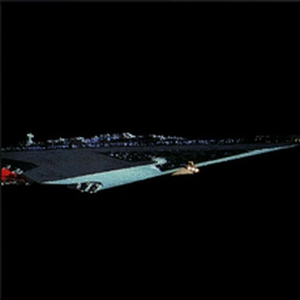

DEBUG:__main__:+ conexion recibida: 807bd872-e7b8-4eef-91c1-a93cf9a9cb59
DEBUG:__main__:- imagen preparada
DEBUG:__main__:- resultado del modelo: [[9.9999249e-01 1.9301067e-12 6.1555282e-11 6.9303428e-06 4.2183859e-07
  1.7615766e-09 3.1756784e-08 8.1512601e-09 1.0809358e-12 8.7864265e-08
  1.0995882e-09 4.5286028e-09]]
DEBUG:__main__:* clase asignada por modelo: 0
DEBUG:__main__:+ devuelveOK={'claseID': 0, 'clase': 'Command Ships'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:44] "POST /SWimagen HTTP/1.1" 200 -


	 <Response [200]> - {'data': {'clase': 'Command Ships', 'claseID': 0}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Command Ships', 'claseID': 0}



> Imagen:  /content/gdrive/MyDrive/demosColab/demoStarWars/imagenes/ori/TIE Bombers/3d7cf3ff36af4ea298926029f77b4685.png


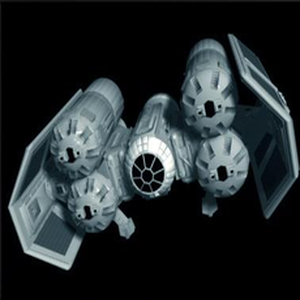

DEBUG:__main__:+ conexion recibida: 3b4a7cd8-d6e1-454d-93c3-3348328fcc2d
DEBUG:__main__:- imagen preparada
DEBUG:__main__:- resultado del modelo: [[1.28187856e-20 5.68888605e-14 1.92836876e-13 4.27339804e-12
  1.23725564e-20 4.87331301e-16 1.72786962e-17 1.00000000e+00
  1.44087471e-21 2.99219850e-11 4.78924799e-12 1.64973628e-20]]
DEBUG:__main__:* clase asignada por modelo: 7
DEBUG:__main__:+ devuelveOK={'claseID': 7, 'clase': 'TIE Bombers'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:47] "POST /SWimagen HTTP/1.1" 200 -


	 <Response [200]> - {'data': {'clase': 'TIE Bombers', 'claseID': 7}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'TIE Bombers', 'claseID': 7}



> Imagen:  /content/gdrive/MyDrive/demosColab/demoStarWars/imagenes/ori/Command Ships/0c4e4cc6fa404743bdb32799af176bc9.png


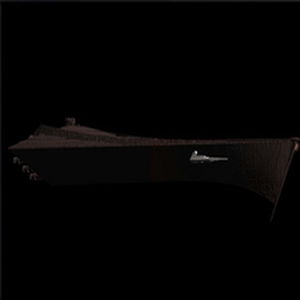

DEBUG:__main__:+ conexion recibida: 717226ce-0c45-4a80-9d74-802d157b3636
DEBUG:__main__:- imagen preparada
DEBUG:__main__:- resultado del modelo: [[1.0000000e+00 1.4071315e-14 3.4714078e-15 4.5353291e-12 3.1300604e-11
  6.3099563e-15 2.7909409e-11 1.3476390e-13 1.6593459e-16 4.5225830e-14
  2.1465155e-18 2.2200639e-13]]
DEBUG:__main__:* clase asignada por modelo: 0
DEBUG:__main__:+ devuelveOK={'claseID': 0, 'clase': 'Command Ships'}
INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 14:20:57] "POST /SWimagen HTTP/1.1" 200 -


	 <Response [200]> - {'data': {'clase': 'Command Ships', 'claseID': 0}, 'message': 'Success', 'statusCode': 200}

> Resultado API:  {'clase': 'Command Ships', 'claseID': 0}



In [31]:
#@title Probar Web API local para Imágenes con un ejemplo tomado al azar del drive

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random

import json
import requests

strAZAR = "-AZAR-"
path_imagenes = "/content/gdrive/MyDrive/demosColab/demoStarWars/imagenes"  #@param {type:"string"}

# función auxiliar para probar API
def ejecutarModelWebAPI_imagenes(imageFN, URL_API, mostrarRes=True):
  # prepara la info de la imagen a mandar como archivo
  dictValues = {'image': (os.path.basename(imageFN),
                          open(imageFN, "rb").read(),
                          #'multipart/form-data',
                           {'Expires': '0'}) }
  # ejecuta la web API
    # ejecuta la web API usando request
  headers = {"ngrok-skip-browser-warning": "69420" }
  json_response = requests.post(URL_API, files=dictValues, headers=headers)
  if json_response.status_code == 200:
    res = json.loads(json_response.text)
    if mostrarRes:
      print("\t", json_response, "-", res)
    return res["data"]
  else:
    if mostrarRes:
      print("\t", json_response, ":", json_response.content)
    return "ERROR"

def procesarImagen(imageFN):
  print("\n> Imagen: ", imageFN)
  display( Image.open(imageFN) )
  # ejecuta API
  res = ejecutarModelWebAPI_imagenes(imageFN,
                                    nombre_WebAPI_imagenes)
  print("\n> Resultado API: ",  res)
  print("")
  return res

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  # determina directorio y elege un archivo al azar
  if combo_clase.value==strAZAR:
    combo_clase_dir = random.choice(all_image_classes[0:-1])
  else:
    combo_clase_dir = combo_clase.value
  class_path = path_imagenes + "/" + path_imagenes_tipo.value + "/" + combo_clase_dir
  images_in_class_path = os.listdir( class_path )
  imageFN = random.choice(images_in_class_path)
  procesarImagen(class_path + "/" + imageFN)

# permite seleccionar una clase y toma una imagen al azar
subdirs = list( os.listdir( path_imagenes) )
subdirs.sort()
path_imagenes_tipo = widgets.Dropdown(
    options = subdirs,
    value = subdirs[0],
    description = "Tipo path imágenes:",
    disabled = False,
    style= {'description_width': 'initial', 'width': 'initial'}
)
all_image_classes = os.listdir( path_imagenes + "/" + path_imagenes_tipo.value )
all_image_classes.append( strAZAR )
combo_clase = widgets.Dropdown(
    options = all_image_classes,
    description = 'Clase a procesar:',
    value = strAZAR,
    disabled = False,
    style= {'description_width': 'initial', 'width': 'initial'}
)
# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Ejecutar'
)
configDatos_ui = widgets.GridBox(
      children=[ path_imagenes_tipo, combo_clase, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

on_buttonAplicar_clicked(btnAplicar)

In [ ]:
#@title Mostrar Archivo de Log
print("")
mostrarLog()
print("")